<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/signal_kalman_nifty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [28]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
pd.options.mode.chained_assignment = None

In [30]:
#ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_niftybanklist.csv')

In [31]:
ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv')
START = "2013-01-01"

In [32]:
nifty=yf.download('^nsei',start=START)

[*********************100%***********************]  1 of 1 completed


In [33]:
lst=[]
for i in range(len(ticker)):
  
  dfi = yf.download(str(ticker.Symbol.iloc[i])+'.ns', start=START)
  df = dfi[['Adj Close']]
  f = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = 0,
                    initial_state_covariance = 1,
                    observation_covariance = 1,
                    transition_covariance = 0.0001)
  mean, cov = f.filter(df['Adj Close'].values)
  mean, std = mean.squeeze(), np.std(cov.squeeze())
  var = 'kalman'
  df[var]=df['Adj Close'].values - mean
  
  lst.append(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [34]:
nlst=[]
for i in range(len(ticker)):
  nlst.append(lst[i].kalman)
  

In [35]:
df_kalman = pd.DataFrame(nlst).T

In [36]:
namelist =[]
for i in range(1,len(ticker)+1):
  namelist.append('kalman_'+str(i))
  
df_kalman.columns = namelist

In [37]:
def macd_calc(df):
  columns=df.columns.tolist()
  for var in columns:
    macd='macd'+var
    macd_s='macd'+'signal'+var
    macd_h='hist'+ var
    df[macd]=df[var].ewm(span=26, adjust=False).mean()-df[var].ewm(span=50, adjust=False).mean()
    df[macd_s]=df[macd].ewm(span=18,adjust=False).mean()
    df[macd_h]=df[macd]-df[macd_s]
  return df

In [38]:
final_kalman=macd_calc(df_kalman)

In [39]:
final_kalman.tail(2)

,kalman_1,kalman_2,kalman_3,kalman_4,kalman_5,kalman_6,kalman_7,kalman_8,kalman_9,kalman_10,kalman_11,kalman_12,kalman_13,kalman_14,kalman_15,kalman_16,kalman_17,kalman_18,kalman_19,kalman_20,kalman_21,kalman_22,kalman_23,kalman_24,kalman_25,kalman_26,kalman_27,kalman_28,kalman_29,kalman_30,kalman_31,kalman_32,kalman_33,kalman_34,kalman_35,kalman_36,kalman_37,kalman_38,kalman_39,kalman_40,...,histkalman_37,macdkalman_38,macdsignalkalman_38,histkalman_38,macdkalman_39,macdsignalkalman_39,histkalman_39,macdkalman_40,macdsignalkalman_40,histkalman_40,macdkalman_41,macdsignalkalman_41,histkalman_41,macdkalman_42,macdsignalkalman_42,histkalman_42,macdkalman_43,macdsignalkalman_43,histkalman_43,macdkalman_44,macdsignalkalman_44,histkalman_44,macdkalman_45,macdsignalkalman_45,histkalman_45,macdkalman_46,macdsignalkalman_46,histkalman_46,macdkalman_47,macdsignalkalman_47,histkalman_47,macdkalman_48,macdsignalkalman_48,histkalman_48,macdkalman_49,macdsignalkalman_49,histkalman_49,macdkalman_50,macdsignalkalman_50,histkalman_50
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-04,34.543307,287.137847,24.508328,57.783726,1286.781580,4077.254093,5.480633,102.280792,-5.797965,23.822510,21.946708,789.943577,-72.313730,61.197575,367.973302,143.332263,101.352786,13.031009,-192.853090,80.840658,-8.498384,317.832537,133.291917,14.028740,27.380738,176.841743,219.878793,72.998883,231.610366,379.882812,92.686323,648.254943,23.767604,816.335671,31.884101,16.672638,280.306266,128.475264,1664.049674,126.580011,...,-26.303228,-12.950908,-4.527248,-8.423660,-232.384865,-236.941274,4.556409,10.166453,5.995904,4.170549,-1.91530,2.793808,-4.709109,-73.519704,-29.574519,-43.945185,-14.240575,-11.184872,-3.055704,33.577202,26.859606,6.717596,-41.767219,-40.783084,-0.984136,8.634041,12.88131,-4.247270,66.942972,75.307680,-8.364708,-15.568951,-18.922660,3.353709,-92.881704,-123.471060,30.589356,-6.179383,-1.466000,-4.713384
2021-11-08,50.782932,263.242230,22.383349,74.980118,1421.049658,4755.213602,17.306698,109.084503,58.711827,26.555622,22.718385,473.831897,-49.218976,109.744531,421.091257,141.658577,106.581676,19.683166,-185.588005,77.264126,0.545934,393.725643,130.035097,17.106814,32.850589,48.405312,246.204457,79.400846,290.540495,391.547805,78.546941,579.629786,26.649780,966.621009,34.388483,20.565939,280.586193,145.908886,2122.074126,118.192153,...,-28.096504,-12.393090,-5.355231,-7.037859,-192.988753,-232.314692,39.325940,10.327367,6.451848,3.875519,-2.66956,2.218717,-4.888277,-74.952539,-34.351152,-40.601387,-13.778844,-11.457922,-2.320923,33.457138,27.554083,5.903055,-40.895253,-40.794891,-0.100362,9.636108,12.53971,-2.903603,67.730306,74.510061,-6.779756,-14.705942,-18.478795,3.772853,-68.631981,-117.698525,49.066544,-6.714607,-2.018485,-4.696122


In [40]:
features = final_kalman.columns.tolist()

In [41]:
feats_set1=[feats for feats in features if feats.startswith('hist')]

In [42]:
final_dataframe=final_kalman[feats_set1]

In [43]:
solution=np.sign(final_dataframe)

In [44]:
solution['final']=solution.sum(axis=1)

In [45]:
solution.tail(2)

,histkalman_1,histkalman_2,histkalman_3,histkalman_4,histkalman_5,histkalman_6,histkalman_7,histkalman_8,histkalman_9,histkalman_10,histkalman_11,histkalman_12,histkalman_13,histkalman_14,histkalman_15,histkalman_16,histkalman_17,histkalman_18,histkalman_19,histkalman_20,histkalman_21,histkalman_22,histkalman_23,histkalman_24,histkalman_25,histkalman_26,histkalman_27,histkalman_28,histkalman_29,histkalman_30,histkalman_31,histkalman_32,histkalman_33,histkalman_34,histkalman_35,histkalman_36,histkalman_37,histkalman_38,histkalman_39,histkalman_40,histkalman_41,histkalman_42,histkalman_43,histkalman_44,histkalman_45,histkalman_46,histkalman_47,histkalman_48,histkalman_49,histkalman_50,final
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-04,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-28.0
2021-11-08,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-28.0


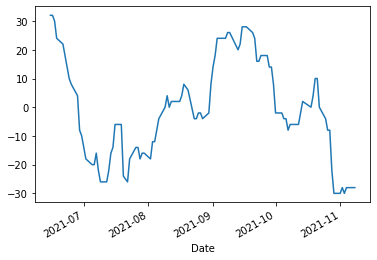

In [46]:
solution.final[-100:].plot()

In [47]:
l=700

In [48]:
nifty=nifty[-l:]
solution=solution[-l:]

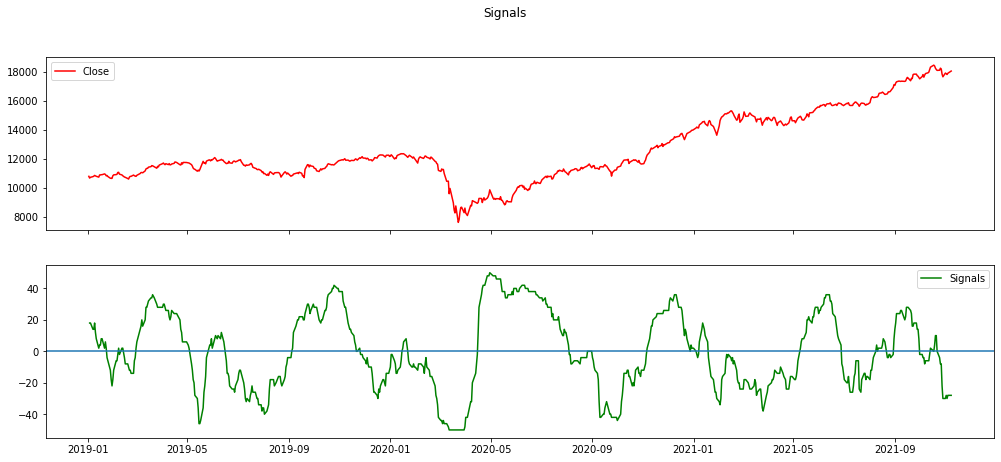

In [49]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'g', label='Signals')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

In [50]:
solution['signals']=np.where(solution['final']>0,1,-1)

In [51]:
if solution['signals'].iloc[-1]!=solution['signals'].iloc[-2]:
  var= solution['signals'].iloc[-1]
  print(f'signal changed to : {var}')
else :
  var= solution['signals'].iloc[-1]
  print(f'signal unchanged (1:stay long , -1: stay short) : {var}')

signal unchanged (1:stay long , -1: stay short) : -1


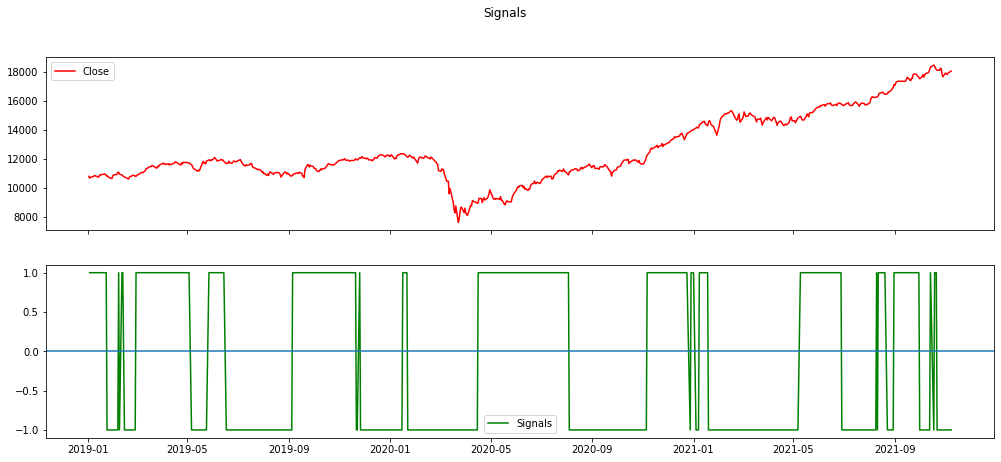

In [52]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'signals'],'g', label='Signals')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()